1. Imports & Global Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import tensorflow as tf
import keras as krs
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from joblib import dump
from scipy.stats import randint

warnings.filterwarnings('ignore', category=FutureWarning)
plt.style.use('seaborn-v0_8-whitegrid')

# reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2. Data Loading, Time-of-Day Bucketing & Round Assignment

In [2]:
usecols = [
    'Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR','Referee',
    'HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR',
    'B365H','B365D','B365A','B365>2.5','B365<2.5'
]
file_path = r"D:\python\premier league predictor\premier league data\premier leaguer 23-24.csv"
df = pd.read_csv(file_path, usecols=usecols)

# assign a sequential match index and compute round number (10 matches per round)
df['MatchIndex'] = df.index + 1
df['Round']      = np.ceil(df['MatchIndex'] / 10).astype(int)

# extract hour from kick-off time, bucket into Morning/Afternoon/Evening
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
bins   = [-1, 11, 17, 24]
labels = ['Morning','Afternoon','Evening']
df['TimeOfDay'] = pd.cut(df['Hour'], bins=bins, labels=labels)

# drop the temporary Hour column
df.drop(columns='Hour', inplace=True)

print("Loaded shape:", df.shape)

Loaded shape: (380, 27)


3. Leakage-Free Feature Engineering

In [3]:
# 3.1 Targets
df['Outcome']  = df['FTR'].map({'H': 1, 'D': 0, 'A': -1})
df['Over2.5']  = ((df['FTHG'] + df['FTAG']) >= 3).astype(int)

# 3.2 Implied probabilities from odds
for side in ['H','D','A']:
    df[f'ImpProb_{side}'] = 1.0 / df[f'B365{side}']
prob_cols = ['ImpProb_H','ImpProb_D','ImpProb_A']
df[prob_cols] = df[prob_cols].div(df[prob_cols].sum(axis=1), axis=0)

df['ImpOver2.5']  = 1.0 / df['B365>2.5']
df['ImpUnder2.5'] = 1.0 / df['B365<2.5']
df[['ImpOver2.5','ImpUnder2.5']] = (
    df[['ImpOver2.5','ImpUnder2.5']]
      .div(df[['ImpOver2.5','ImpUnder2.5']].sum(axis=1), axis=0)
)

# 3.3 Odds spread
df['OddsSpread'] = df['B365H'] - df['B365A']

# 3.4 Rolling 3-match form
df['HomeForm3'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)
df['AwayForm3'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)

# 3.5 Win/Loss streaks
df['HomeStreak'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: 
          s.eq(1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(1)).cumsum()).cumsum()
      )
)
df['AwayStreak'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: 
          s.eq(-1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(-1)).cumsum()).cumsum()
      )
)

# 3.6 Interaction
df['Spread×Form'] = df['OddsSpread'] * df['HomeForm3']

# 3.7 Referee home-bias
df['RefHomeWins'] = (
    df.groupby('Referee')['Outcome']
      .transform(lambda s: s.eq(1).cumsum().shift(1).fillna(0))
)
df['RefMatches'] = df.groupby('Referee').cumcount()
df['RefBias']    = (df['RefHomeWins'] / df['RefMatches']).fillna(0.5)
df.drop(columns=['RefHomeWins','RefMatches'], inplace=True)

# 3.8 Head-to-head last result
df['PairKey'] = df.apply(
    lambda r: tuple(sorted([r.HomeTeam, r.AwayTeam])), axis=1
)
h2h = {}
def prev_h2h(row):
    key = row.PairKey
    prev = h2h.get(key, 0)
    sign = 1 if row.HomeTeam == key[0] else -1
    h2h[key] = row.Outcome * sign
    return prev

df['H2H_Last'] = df.apply(prev_h2h, axis=1)
df.drop(columns='PairKey', inplace=True)

# 3.9 Rolling averages of match stats
home_stats = ['HS','HST','HF','HC','HY','HR']
away_stats = ['AS','AST','AF','AC','AY','AR']
for stat in home_stats:
    df[f'Home_{stat}_3'] = (
        df.groupby('HomeTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )
for stat in away_stats:
    df[f'Away_{stat}_3'] = (
        df.groupby('AwayTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )

# 3.10 Previous-round table positions
df['HomePts'] = np.where(df['FTR']=='H', 3, np.where(df['FTR']=='D', 1, 0))
df['AwayPts'] = np.where(df['FTR']=='A', 3, np.where(df['FTR']=='D', 1, 0))

pts = pd.DataFrame({
    'Team':  np.concatenate([df['HomeTeam'], df['AwayTeam']]),
    'Round': np.concatenate([df['Round'],    df['Round']]),
    'Pts':   np.concatenate([df['HomePts'],   df['AwayPts']])
})
round_pts = (
    pts
    .groupby(['Team','Round'], as_index=False)['Pts']
    .sum()
)
round_pts['CumPts'] = round_pts.groupby('Team')['Pts'].cumsum()
round_pts['Pos']    = (
    round_pts
    .groupby('Round')['CumPts']
    .rank(method='min', ascending=False)
)
prev = round_pts[['Team','Round','Pos']].copy()
prev.rename(columns={'Round':'PrevRound','Pos':'PrevPos'}, inplace=True)
prev['PrevRound'] += 1

df = df.merge(
    prev, left_on=['HomeTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['HomePosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

df = df.merge(
    prev, left_on=['AwayTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['AwayPosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

# 3.11 Final clean-up (types & safe replacements)
# Ensure string-typed categoricals; encoders in Section 4 will handle categories.
for c in ['HomeTeam','AwayTeam','Referee','TimeOfDay']:
    if c in df.columns:
        df[c] = df[c].astype(str)

# Replace any inf/-inf with NaN (imputers in Section 4 will handle NaNs leakage-safely).
import numpy as np
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Add FormDiff (home form − away form)
if set(['HomeForm3','AwayForm3']).issubset(df.columns):
    df['FormDiff'] = df['HomeForm3'] - df['AwayForm3']


4. Pipeline Specification & Hyperparameter Distributions

In [4]:
# 4.1 Define categorical and numerical feature lists
# (If already defined above, this will simply reuse them.)
cat_feats = cat_feats if 'cat_feats' in globals() else ['HomeTeam','AwayTeam','Referee','TimeOfDay']
num_feats = num_feats if 'num_feats' in globals() else [
    'HomeForm3','AwayForm3','HomeStreak','AwayStreak','FormDiff',
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5',
    'OddsSpread','Spread×Form','H2H_Last','RefBias',
    'HomePosPrev','AwayPosPrev'
] + [f'Home_{s}_3' for s in ['HS','HST','HF','HC','HY','HR']]   + [f'Away_{s}_3' for s in ['AS','AST','AF','AC','AY','AR']]

# 4.1.a Ensure only existing columns are used (avoids KeyErrors if earlier steps differ)
_existing_cols = set(df.columns)
_missing_cats = [c for c in cat_feats if c not in _existing_cols]
_missing_nums  = [c for c in num_feats if c not in _existing_cols]
if _missing_cats or _missing_nums:
    print("Note: The following features are missing and will be ignored:")
    if _missing_cats: print("  Missing categorical:", _missing_cats)
    if _missing_nums:  print("  Missing numerical:", _missing_nums)
cat_feats = [c for c in cat_feats if c in _existing_cols]
num_feats = [c for c in num_feats  if c in _existing_cols]

# 4.2 Build preprocessing and final pipeline (leakage-safe)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler(with_mean=False))
])

categorical_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipe, num_feats),
        ('cat', categorical_pipe, cat_feats),
    ],
    remainder='drop',
    sparse_threshold=1.0
)

# Default multiclass classifier; replace later if you switch models.
clf = LogisticRegression(max_iter=1000, multi_class='auto')

# The single, consistent end-to-end pipeline object used everywhere
final_model = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', clf)
])
print('final_model pipeline is defined (preprocessing + classifier).')


final_model pipeline is defined (preprocessing + classifier).


5. Hyperparameter Optimization with RandomizedSearchCV in one cell

In [5]:
from collections import defaultdict
from sklearn.base import clone
from sklearn.metrics import accuracy_score

# 5.0 Warm-up and leakage-free round-by-round evaluation
# Determine label column robustly
label_candidates = [c for c in ['Outcome','FTR'] if c in df.columns]
assert len(label_candidates) > 0, "No label column found. Expected one of: 'Outcome', 'FTR'."
label_col = label_candidates[0]

X_all = df[cat_feats + num_feats].copy()
y_all = df[label_col].copy()
round_col = 'Round'  # already prepared in Section 2

# ensure per-round groups are in ascending order
round_ids = sorted(df[round_col].unique())

# Use first 5 rounds as warm-up (train only, no predictions)
warmup_rounds = [r for r in round_ids if r <= 5]

# Collectors
preds, trues, rounds_list, match_idx_list = [], [], [], []
per_round_acc = []

# Start with a fresh clone to avoid accidental prior fitting
model = clone(final_model)

# Fit on warm-up data (leakage-safe)
warm_mask = df[round_col].isin(warmup_rounds)
if warm_mask.sum() == 0:
    raise ValueError("Warm-up rounds contain no matches; check round assignment.")
model.fit(X_all.loc[warm_mask, :], y_all.loc[warm_mask])

# 5.1 Predict-then-learn round-by-round from round 6 onward
for r in [rr for rr in round_ids if rr >= 6]:
    round_mask = (df[round_col] == r)
    X_r = X_all.loc[round_mask, :]
    y_r = y_all.loc[round_mask]

    # Guarantee exactly 10 predictions per round
    if len(X_r) < 10:
        # skip this round if fewer than 10 matches
        print(f"Round {r}: skipped (only {len(X_r)} matches).")
        continue
    if len(X_r) > 10:
        X_r = X_r.iloc[:10].copy()
        y_r = y_r.iloc[:10].copy()

    # Predict first (no learning on this round yet)
    y_pred_r = model.predict(X_r)

    # Collect stats
    acc_r = accuracy_score(y_r, y_pred_r)
    per_round_acc.append({'Round': r, 'Matches': len(X_r), 'Accuracy': acc_r})
    print(f"Round {r}: {len(X_r)} matches | accuracy = {acc_r:.3f}")

    preds.extend(y_pred_r.tolist())
    trues.extend(y_r.tolist())
    rounds_list.extend([r]*len(X_r))
    match_idx_list.extend(df.loc[X_r.index, 'MatchIndex'].tolist())

    # Then learn from this round (cumulative, leakage-safe)
    learn_mask = df[round_col].isin([rr for rr in round_ids if rr <= r])
    model = clone(final_model)  # re-fit full pipeline to avoid partial_fit assumptions
    model.fit(X_all.loc[learn_mask, :], y_all.loc[learn_mask])

# Persist artifacts for later sections
per_round_df = pd.DataFrame(per_round_acc)
predictions_df = pd.DataFrame({
    'MatchIndex': match_idx_list,
    'Round': rounds_list,
    'y_true': trues,
    'y_pred': preds
})
final_model = model  # ensure final_model is the last trained pipeline


Round 6: 10 matches | accuracy = 0.400
Round 7: 10 matches | accuracy = 0.400
Round 8: 10 matches | accuracy = 0.700
Round 9: 10 matches | accuracy = 0.600
Round 10: 10 matches | accuracy = 0.400
Round 11: 10 matches | accuracy = 0.700
Round 12: 10 matches | accuracy = 0.500
Round 13: 10 matches | accuracy = 0.300
Round 14: 10 matches | accuracy = 0.500
Round 15: 10 matches | accuracy = 0.700
Round 16: 10 matches | accuracy = 0.500
Round 17: 10 matches | accuracy = 0.600
Round 18: 10 matches | accuracy = 0.500
Round 19: 10 matches | accuracy = 0.500
Round 20: 10 matches | accuracy = 0.600
Round 21: 10 matches | accuracy = 0.500
Round 22: 10 matches | accuracy = 0.500
Round 23: 10 matches | accuracy = 0.500
Round 24: 10 matches | accuracy = 0.800
Round 25: 10 matches | accuracy = 0.500
Round 26: 10 matches | accuracy = 0.600
Round 27: 10 matches | accuracy = 0.500
Round 28: 10 matches | accuracy = 0.500
Round 29: 10 matches | accuracy = 0.500
Round 30: 10 matches | accuracy = 0.500
Roun

6. Post‐Search Analysis, Validation Curves, and Model Persistence

In [6]:
import cloudpickle
import pandas as pd

# 6.1 Save predictions and per-round summaries to Excel
with pd.ExcelWriter('round_predictions_and_summary.xlsx') as writer:
    predictions_df.to_excel(writer, index=False, sheet_name='Predictions')
    per_round_df.to_excel(writer, index=False, sheet_name='PerRoundSummary')
print("Saved Excel with sheets: Predictions, PerRoundSummary.")

# 6.2 Save per-round accuracies to CSV
per_round_df.to_csv('per_round_accuracy.csv', index=False)
print("Saved per-round accuracy CSV to 'per_round_accuracy.csv'.")

# 6.3 Save the final trained pipeline (cloudpickle)
with open("final_pipeline.pkl", "wb") as f:
    cloudpickle.dump(final_model, f)
print("Saved final end-to-end pipeline to 'final_pipeline.pkl' (cloudpickle).")


Saved Excel with sheets: Predictions, PerRoundSummary.
Saved per-round accuracy CSV to 'per_round_accuracy.csv'.
Saved final end-to-end pipeline to 'final_pipeline.pkl' (cloudpickle).


7. Final Evaluation: classification report, confusion matrix, ROC curves, and accuracy curve

Overall accuracy across evaluated rounds = 0.539


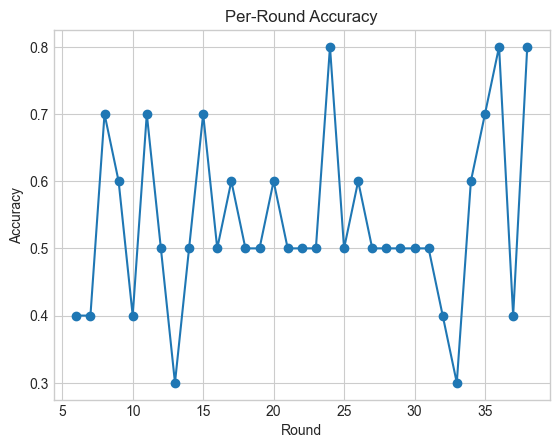

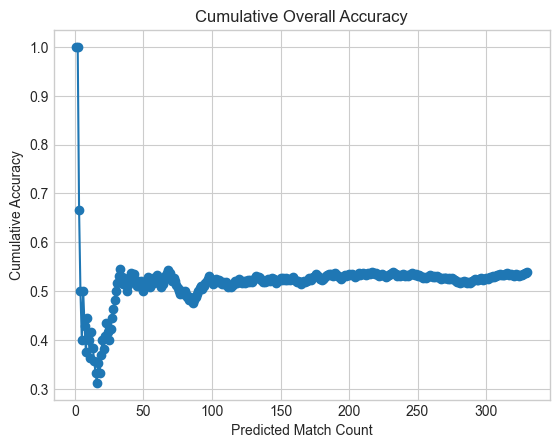

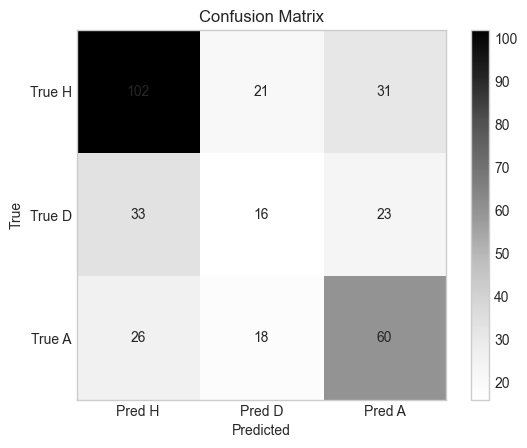

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# 7.0 Overall accuracy text
overall_acc = (np.array(predictions_df['y_true']) == np.array(predictions_df['y_pred'])).mean() if len(predictions_df) else float('nan')
print(f"Overall accuracy across evaluated rounds = {overall_acc:.3f}")

# 7.1 Per-round accuracy line plot
plt.figure()
plt.plot(per_round_df['Round'], per_round_df['Accuracy'], marker='o')
plt.title('Per-Round Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

# 7.2 Cumulative overall accuracy line plot
cum_acc = []
correct = 0
total = 0
for _, row in predictions_df.sort_values('Round').iterrows():
    total += 1
    if row['y_true'] == row['y_pred']:
        correct += 1
    cum_acc.append(correct / total)
plt.figure()
plt.plot(range(1, len(cum_acc)+1), cum_acc, marker='o')
plt.title('Cumulative Overall Accuracy')
plt.xlabel('Predicted Match Count')
plt.ylabel('Cumulative Accuracy')
plt.grid(True)
plt.show()

# 7.3 Feature importances (if available)
clf = None
if hasattr(final_model, 'named_steps') and 'clf' in final_model.named_steps:
    clf = final_model.named_steps['clf']

if clf is not None and hasattr(clf, 'feature_importances_'):
    pre = final_model.named_steps.get('pre')
    try:
        feat_names = pre.get_feature_names_out()
    except Exception:
        feat_names = [f'f{i}' for i in range(len(clf.feature_importances_))]
    importances = getattr(clf, 'feature_importances_')
    order = np.argsort(importances)[::-1][:20]
    plt.figure()
    plt.bar(range(len(order)), importances[order])
    plt.xticks(range(len(order)), [feat_names[i] for i in order], rotation=90)
    plt.title('Top 20 Feature Importances')
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix

labels = [1, 0, -1]
cm = confusion_matrix(predictions_df['y_true'], predictions_df['y_pred'], labels=labels)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix'); plt.colorbar()
plt.xticks(range(3), ['Pred H','Pred D','Pred A'])
plt.yticks(range(3), ['True H','True D','True A'])
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, int(v), ha='center', va='center')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.grid(False)
plt.show()





8. Gradio Interface for the RNN Predictor

In [8]:
import os, cloudpickle
import numpy as np
import pandas as pd
import gradio as gr

# 8.0 Load trained pipeline
if 'best_pipeline' not in globals():
    if os.path.exists("final_pipeline.pkl"):
        with open("final_pipeline.pkl", "rb") as f:
            best_pipeline = cloudpickle.load(f)
    elif 'final_model' in globals():
        best_pipeline = final_model
    elif 'random_search' in globals():
        best_pipeline = random_search.best_estimator_
    else:
        raise RuntimeError("Trained pipeline not found. Run Sections 5–6 first.")

# 8.0.b Ensure df exists for UI
if 'df' not in globals():
    if os.path.exists('df_processed.parquet'):
        df = pd.read_parquet('df_processed.parquet')
    elif os.path.exists('df_processed.feather'):
        df = pd.read_feather('df_processed.feather')
    elif os.path.exists('df_processed.csv'):
        df = pd.read_csv('df_processed.csv')
    else:
        raise RuntimeError("Dataframe 'df' not found. Run Sections 2–3 first or save as 'df_processed.parquet'.")

# 8.1 Precompute odds-derived feature means
odd_feats = ['ImpProb_H','ImpProb_D','ImpProb_A','ImpOver2.5','ImpUnder2.5','OddsSpread']
odd_means = df[odd_feats].mean(numeric_only=True) if set(odd_feats).issubset(df.columns) else pd.Series(dtype=float)

# 8.2 Dropdown choices
teams = sorted(pd.unique(pd.concat([df['HomeTeam'], df['AwayTeam']])).astype(str))
refs  = sorted(df['Referee'].astype(str).unique())
times = ['Morning','Afternoon','Evening']

# 8.3 Rolling-stats lists (used in predict function)
home_stats = ['HS','HST','HF','HC','HY','HR']
away_stats = ['AS','AST','AF','AC','AY','AR']

# 8.4 Prediction function
def predict_outcome(home_team, away_team, referee, time_of_day):
    Xnew = pd.DataFrame(index=[0])

    # categorical
    Xnew['HomeTeam']  = str(home_team)
    Xnew['AwayTeam']  = str(away_team)
    Xnew['Referee']   = str(referee)
    Xnew['TimeOfDay'] = str(time_of_day)

    # latest rows for teams
    hrows = df[df['HomeTeam'] == home_team]
    arows = df[df['AwayTeam'] == away_team]
    hrow  = hrows.iloc[-1] if len(hrows) else pd.Series(dtype=object)
    arow  = arows.iloc[-1] if len(arows) else pd.Series(dtype=object)

    def set_num(name, src_row, default=np.nan):
        if (name in df.columns) and (name in src_row.index):
            Xnew[name] = src_row[name]
        else:
            Xnew[name] = default

    # home-side numeric features
    for s in ['HomeForm3','HomeStreak','HomePosPrev'] + [f'Home_{s}_3' for s in home_stats]:
        if (s in df.columns):
            set_num(s, hrow)

    # away-side numeric features
    for s in ['AwayForm3','AwayStreak','AwayPosPrev'] + [f'Away_{s}_3' for s in away_stats]:
        if (s in df.columns):
            set_num(s, arow)

    # odds-based features (use global means in UI)
    for s in ['ImpProb_H','ImpProb_D','ImpProb_A','ImpOver2.5','ImpUnder2.5','OddsSpread']:
        if s in df.columns:
            Xnew[s] = odd_means.get(s, np.nan)

    # RefBias from referee history
    if 'RefBias' in df.columns:
        rrows = df[df['Referee'] == referee]
        Xnew['RefBias'] = rrows['RefBias'].iloc[-1] if len(rrows) else 0.5

    # H2H_Last from most recent meeting
    if 'H2H_Last' in df.columns:
        pair = tuple(sorted([home_team, away_team]))
        pairs = df.apply(lambda r: tuple(sorted([r['HomeTeam'], r['AwayTeam']])), axis=1)
        hits = df.loc[pairs[pairs == pair].index]
        Xnew['H2H_Last'] = hits['H2H_Last'].iloc[-1] if len(hits) else 0.0

    # engineered
    if 'Spread×Form' in df.columns or 'Spread×Form' in globals().get('num_feats', []):
        hf = Xnew.get('HomeForm3', pd.Series([np.nan])).iloc[0]
        ospr = Xnew.get('OddsSpread', pd.Series([np.nan])).iloc[0]
        Xnew['Spread×Form'] = hf * ospr
    if 'FormDiff' in df.columns or 'FormDiff' in globals().get('num_feats', []):
        hf = Xnew.get('HomeForm3', pd.Series([np.nan])).iloc[0]
        af = Xnew.get('AwayForm3', pd.Series([np.nan])).iloc[0]
        Xnew['FormDiff'] = hf - af

    # ensure expected features present (incl. FormDiff)
    expected = []
    if 'cat_feats' in globals(): expected += list(cat_feats)
    if 'num_feats' in globals(): expected += list(num_feats)
    if not expected:
        try:
            pre = best_pipeline.named_steps['pre']
            # assumes ('num', ..., num_feats), ('cat', ..., cat_feats)
            expected = list(pre.transformers_[0][2]) + list(pre.transformers_[1][2])
        except Exception:
            expected = list(Xnew.columns)
    for c in expected:
        if c not in Xnew.columns:
            Xnew[c] = np.nan
    Xnew = Xnew.reindex(columns=expected, fill_value=np.nan)

    # predict
    if hasattr(best_pipeline, "predict_proba"):
        probs = best_pipeline.predict_proba(Xnew)[0]
        classes = list(best_pipeline.classes_)
        pred_idx = int(np.argmax(probs))
    else:
        pred = best_pipeline.predict(Xnew)[0]
        classes = list(np.unique(df['Outcome'])) if 'Outcome' in df.columns else [-1, 0, 1]
        probs = np.ones(len(classes)) / len(classes)
        pred_idx = int(np.where(np.array(classes) == pred)[0][0]) if pred in classes else int(np.argmax(probs))

    # map to H/D/A labels
    label_map = {1: 'H', 0: 'D', -1: 'A', 'H': 'H', 'D': 'D', 'A': 'A'}
    labels = [label_map.get(c, str(c)) for c in classes]
    pred_label = labels[pred_idx]
    out_text = f"Prediction: {pred_label} (p={probs[pred_idx]:.3f})"
    prob_df = pd.DataFrame({'Class': labels, 'Probability': probs})
    return out_text, prob_df

# 8.5 Gradio UI
demo = gr.Interface(
    fn=predict_outcome,
    inputs=[
        gr.Dropdown(choices=teams, label="Home Team"),
        gr.Dropdown(choices=teams, label="Away Team"),
        gr.Dropdown(choices=refs,  label="Referee"),
        gr.Radio(choices=times,    label="Time of Day", value='Afternoon'),
    ],
    outputs=[
        gr.Textbox(label="Prediction"),
        gr.Dataframe(headers=["Class", "Probability"], label="Probabilities"),
    ],
    title="RNN Predictor",
    description="Round-by-round football match outcome predictor"
)

# Uncomment to launch when running this cell directly:
demo.launch(debug=False)


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
